In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc 

import warnings
warnings.filterwarnings("ignore")

In [15]:
tf.keras.backend.set_floatx("float64")

# Raissi Paper (Part [1])

In [16]:
number_of_ic_points = 50
number_of_bc1_points = 25
number_of_bc2_points = 25

engine = qmc.LatinHypercube(d=1)


t_d = engine.random(n=number_of_bc1_points + number_of_bc2_points)
temp = np.zeros([number_of_ic_points, 1])
t_d = np.append(temp, t_d, axis=0)

x_d = engine.random(n=number_of_ic_points)
x_d = 2 * (x_d - 0.5)
temp1 = -1 * np.ones([number_of_bc1_points, 1])
temp2 = +1 * np.ones([number_of_bc2_points, 1])
x_d = np.append(x_d, temp1, axis=0)
x_d = np.append(x_d, temp2, axis=0)

Text(0.5, 1.0, 'Data points (BCs & IC)')

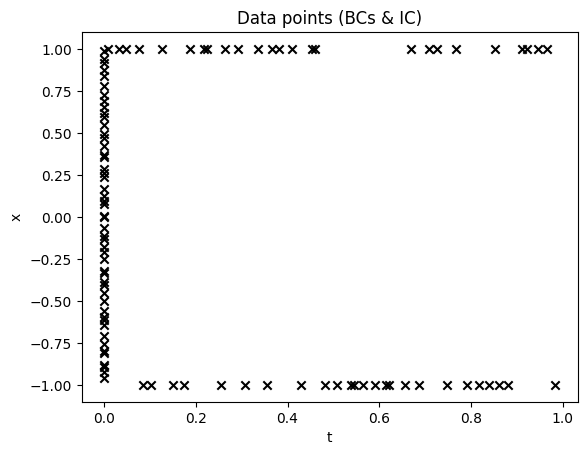

In [17]:
plt.scatter(t_d, x_d, marker="x", c="b")
plt.xlabel("t")
plt.ylabel("x")
plt.title("Data points (BCs & IC)")

In [18]:
y_d = np.zeros(x_d.shape)

y_d[ : number_of_ic_points] = -np.sin(np.pi * x_d[:number_of_ic_points])

y_d[number_of_ic_points : number_of_bc1_points + number_of_ic_points] = 0
y_d[number_of_bc1_points + number_of_ic_points : number_of_bc1_points + number_of_ic_points + number_of_bc2_points] = 0

In [19]:
Nc = 10000

engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)
data[:, 1] = 2*(data[:, 1]-0.5)

t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

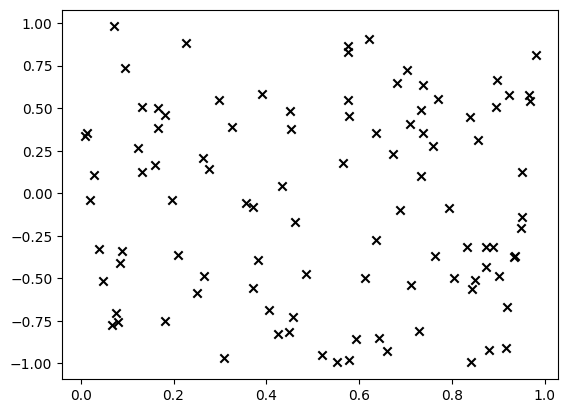

In [20]:
import matplotlib.pyplot as plt
plt.scatter(t_c[0:100] , x_c[0:100] , marker="x", c="b")

In [21]:
x_d, t_d, y_d, x_c, t_c = map(tf.convert_to_tensor, [x_d, t_d, y_d, x_c, t_c])

In [22]:
neuron_per_layer = 20
actfn = "tanh"

input_layer = tf.keras.layers.Input(shape=(2,))

hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)

output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 20)                60        
                                                                 
 dense_11 (Dense)            (None, 20)                420       
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dense_15 (Dense)            (None, 20)                420 

In [23]:
@tf.function
def u(t, x):
    u = model(tf.concat([t, x], axis=1))
    return u

@tf.function
def f(t, x):
    u0 = u(t, x)
    u_t = tf.gradients(u0, t)[0]
    u_x = tf.gradients(u0, x)[0]
    F = u_t + (0.01/np.pi)*u_x
    return tf.reduce_mean(tf.square(F))

@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

In [24]:
import time

In [25]:
epochs = 1000
loss_list = []

opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_ = u(t_d, x_d)
        L1 = f(t_c, x_c)
        L2 = mse(y_d, y_)
        loss = L1 + L2
    g = tape.gradient(loss, model.trainable_weights)
    loss_list.append(loss)
    if (not epoch%50) or (epoch == epochs-1):
        print(f"epoch :- {epoch:4}/{epochs} : {loss.numpy():.6f}")
    opt.apply_gradients(zip(g, model.trainable_weights))

epoch :-    0/1000 : 0.216
epoch :-   50/1000 : 0.176
epoch :-  100/1000 : 0.041
epoch :-  150/1000 : 0.007
epoch :-  200/1000 : 0.003
epoch :-  250/1000 : 0.002
epoch :-  300/1000 : 0.001
epoch :-  350/1000 : 0.001
epoch :-  400/1000 : 0.001
epoch :-  450/1000 : 0.000
epoch :-  500/1000 : 0.000
epoch :-  550/1000 : 0.000
epoch :-  600/1000 : 0.000
epoch :-  650/1000 : 0.000
epoch :-  700/1000 : 0.000
epoch :-  750/1000 : 0.000
epoch :-  800/1000 : 0.000
epoch :-  850/1000 : 0.000
epoch :-  900/1000 : 0.000
epoch :-  950/1000 : 0.001
epoch :-  999/1000 : 0.000


Text(0.5, 0, 'epoch')

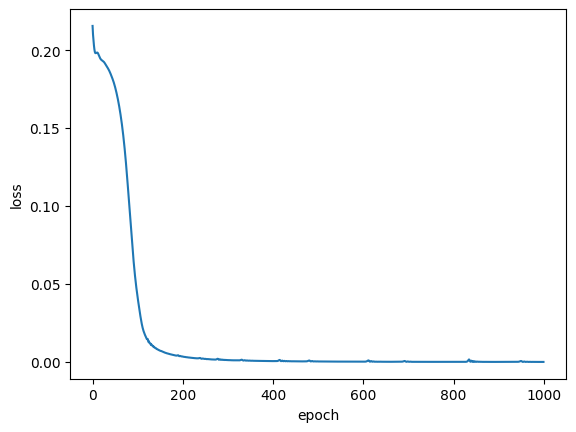

In [26]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

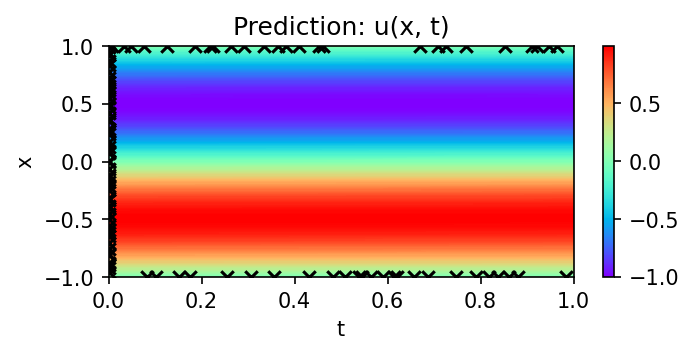

In [30]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=150)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("Prediction: u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

# Analytical Exact Solution

In [28]:
import math
def U_analytical(X,T):
  a = 0.01/np.pi
  X = np.array(X)
  T = np.array(T)
 
  U_ana = -np.sin(np.pi*(X - a*T))  
  return U_ana

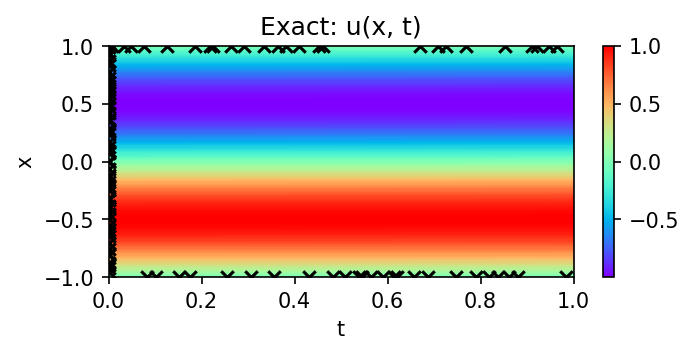

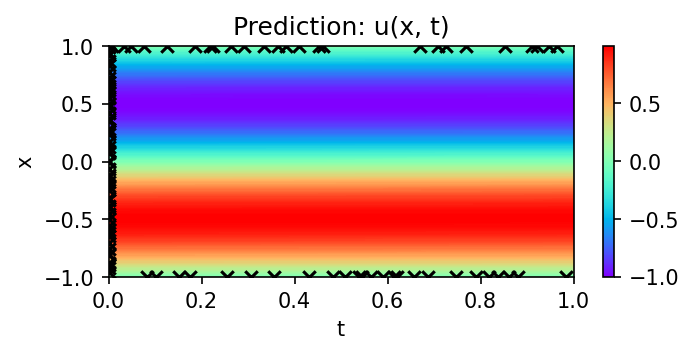

In [32]:
n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])

plt.figure(figsize=(5, 2), dpi=150)
S = U_analytical(X,T)
S = S.reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("Exact: u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

n, m = 100, 200
X = np.linspace(-1, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X = X0.reshape([n*m, 1])
T = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)
X.shape, T.shape
plt.figure(figsize=(5, 2), dpi=150)
S = u(T, X)
S = S.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(-1, +1)
plt.title("Prediction: u(x, t)")
plt.ylabel("x")
plt.xlabel("t")
plt.scatter(t_d, x_d, marker="x", c="k")
plt.show()

- we can observe that our prediction and the exact solution are matching

# Comparison between analytical and PINNs solution

In [33]:
n, m = 100, 200
X = np.linspace(-1, +1, m).reshape((-1,1))
T = np.zeros((m,1))

S = U_analytical(X,T)

63/63 [==============================] - 0s 2ms/step


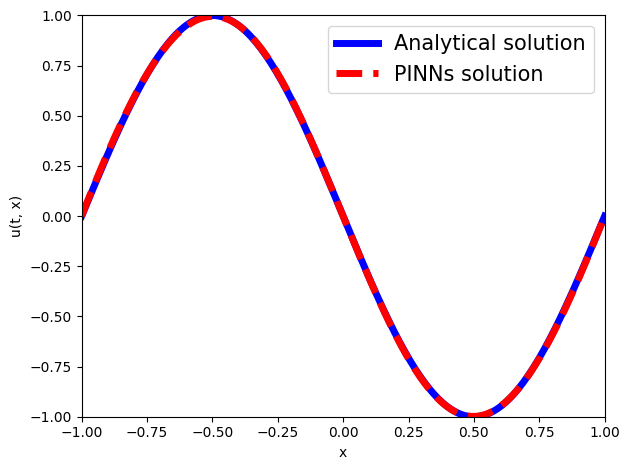

In [34]:
n, m = 100, 200
X = np.linspace(-1, +1, m).reshape((-1,1))
T = np.zeros((m,1))

S = U_analytical(X,T)

plt.plot(X , S  , label = "Analytical solution" , lw = 5, c='b')

n_temporal, n_spatial = 10, 2000
# combine (x, t) as a vector
v = np.zeros([n_spatial, 2]) # v[:, 0] = t, v[:, 1] = x
v[:, 1] = np.linspace(-1, +1, n_spatial)
v[:, 0] = 0
plt.plot(v[:, 1], model.predict(v), label="PINNs solution", lw=5 , linestyle='--', c='r')
plt.legend(loc="upper right", fontsize=15)
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.ylabel(f"u(t, x)")
plt.xlabel(f"x")
plt.tight_layout()
plt.show()

# Lagaris Paper (Part [2])

In [72]:
import tensorflow as tf
input_layer = tf.keras.layers.Input(shape=(2,))
hidden0 = tf.keras.layers.Dense(10, activation="tanh")(input_layer)
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden0)

model_lagg = tf.keras.Model(input_layer, output_layer)

model_lagg.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_28 (Dense)            (None, 10)                30        
                                                                 
 dense_29 (Dense)            (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [73]:
@tf.function
def u(x, y):

    u = model_lagg(tf.concat([x, y], axis=1)) 
    return u

@tf.function
def f(x, y):

    u0 = u(x, y)
    u_y = tf.gradients(u0, y)[0]
    u_x = tf.gradients(u0, x)[0]
    u_xx = tf.gradients(u_x,x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    u_yx = tf.gradients(u_y,x)[0]
    
    e = tf.exp( tf.cast(tf.constant(1.0), tf.float64))
    e_ = tf.exp(tf.cast(tf.constant(-1.0), tf.float64))

    # A = (1 - x)*y**3 + x*(1 + y**3)*e**(-1) + (1 - y)*x*(e**(-x) - e**(-1)) + y*((1 + x)*e**(-x) - (1 - x - 2*x*e**(-1)))
 
    A = (1 - x)*tf.math.pow(y, 3) + x*(1 + tf.math.pow(y, 3))*e_ + (1 - y)*x*(tf.exp(-x) - e_) + y*((1 + x)*tf.exp(-x) - (1 - x - 2*x*e_))
    N = u_xx + u_yy + 2*u_yx - tf.exp(-x)*(x - 2 + tf.math.pow(y, 3) + 6*y)
    F = A + x*(1 - x)*y*(1 - y)*N

    return tf.reduce_mean(tf.square(F))

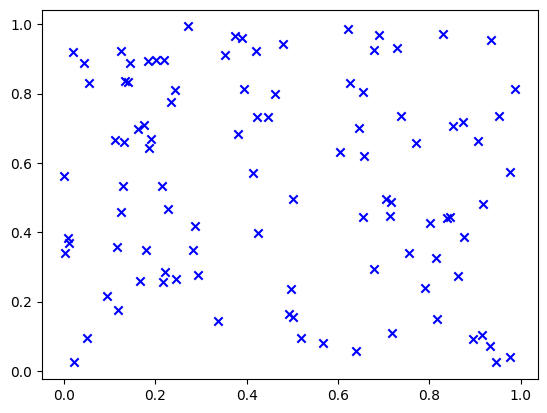

In [74]:
from matplotlib import cm
import numpy as np
from scipy.stats import qmc

Nc = 10000

engine = qmc.LatinHypercube(d=2)
data = engine.random(n=Nc)

t_c = np.expand_dims(data[:, 0], axis=1)
x_c = np.expand_dims(data[:, 1], axis=1)

import matplotlib.pyplot as plt
plt.scatter(t_c[0:100] , x_c[0:100] , marker="x", c="b")

In [75]:
x_c, t_c = map(tf.convert_to_tensor, [ x_c, t_c])

epochs = 25000
loss_list = []

opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

for epoch in range(epochs):
    with tf.GradientTape() as tape:

        L1 = f(x_c, t_c)
        loss = L1 
    g = tape.gradient(loss, model_lagg.trainable_weights)
    loss_list.append(loss)
    if (not epoch%2500) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.6f}")
    opt.apply_gradients(zip(g, model_lagg.trainable_weights))

epoch -    0 /25000 : 0.758934
epoch - 2500 /25000 : 0.343528
epoch - 5000 /25000 : 0.222081
epoch - 7500 /25000 : 0.150111
epoch - 10000 /25000 : 0.113654
epoch - 12500 /25000 : 0.091425
epoch - 15000 /25000 : 0.076803
epoch - 17500 /25000 : 0.064149
epoch - 20000 /25000 : 0.055445
epoch - 22500 /25000 : 0.049032
epoch - 24999 /25000 : 0.042538


Text(0.5, 0, 'epoch')

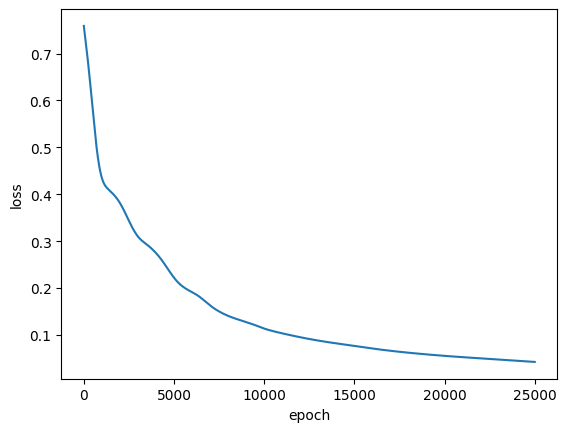

In [76]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

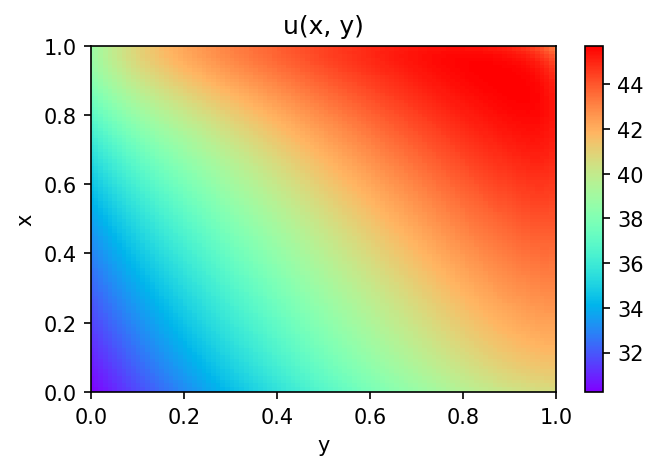

In [77]:
n, m = 100, 100
X = np.linspace(0, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X1 = X0.reshape([n*m, 1])
T1 = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X1)
T = tf.convert_to_tensor(T1)
X.shape, T.shape
plt.figure(figsize=(5, 3), dpi=150)
S1 = u(T, X)
S = S1.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y)")
plt.ylabel("x")
plt.xlabel("y")
plt.show()

In [78]:
def ff(x, y):
    return np.exp(-x)*(x + np.power(y , 3))

x = np.linspace(0, 1, 30)
y = np.linspace(0, 1, 30)

X, Y = np.meshgrid(x, y)
Z = ff(X, Y)

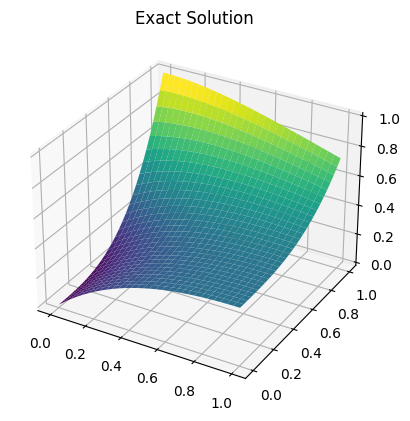

In [79]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Exact Solution');

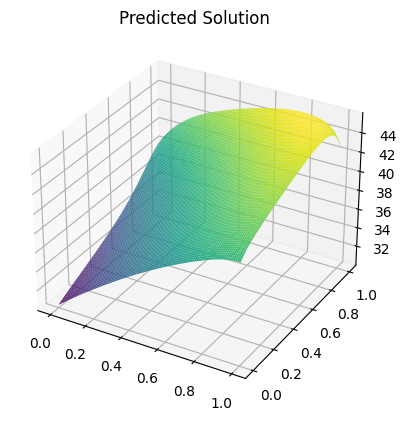

In [80]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_surface(T0, X0, S, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Predicted Solution');

- we can observe that as we have only 10 neurons and 1 hidden layer, we cannot get a exact solution

# 2b

In [81]:
import tensorflow as tf
neuron_per_layer = 10
input_layer = tf.keras.layers.Input(shape=(2,))
hidden0 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)
hidden1 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden0)
hidden2 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden1)
hidden3 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden2)
hidden4 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden3)
hidden5 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden4)
hidden6 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden5)
hidden7 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden6)
hidden8 = tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden7)
output_layer = tf.keras.layers.Dense(1, activation=None)(hidden8)

model_lagg = tf.keras.Model(input_layer, output_layer)

model_lagg.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_30 (Dense)            (None, 10)                30        
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
 dense_33 (Dense)            (None, 10)                110       
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 10)                110 

In [ ]:
x_c, t_c = map(tf.convert_to_tensor, [ x_c, t_c])

epochs = 10000
loss_list = []

opt = tf.keras.optimizers.Adam(learning_rate=5e-4)

for epoch in range(epochs):
    with tf.GradientTape() as tape:

        L1 = f(x_c, t_c)
        loss = L1 
    g = tape.gradient(loss, model_lagg.trainable_weights)
    loss_list.append(loss)
    if (not epoch%1000) or (epoch == epochs-1):
        print(f"epoch - {epoch:4} /{epochs} : {loss.numpy():.6f}")
    opt.apply_gradients(zip(g, model_lagg.trainable_weights))

In [ ]:
plt.plot(range(epochs), loss_list)
plt.ylabel("loss")
plt.xlabel("epoch")

In [ ]:
n, m = 100, 100
X = np.linspace(0, +1, m)
T = np.linspace(0, 1, n)
X0, T0 = np.meshgrid(X, T)
X1 = X0.reshape([n*m, 1])
T1 = T0.reshape([n*m, 1])
X = tf.convert_to_tensor(X1)
T = tf.convert_to_tensor(T1)
X.shape, T.shape
plt.figure(figsize=(5, 3), dpi=150)
S1 = u(T, X)
S = S1.numpy().reshape(n, m)
plt.pcolormesh(T0, X0, S, cmap=cm.rainbow)
plt.colorbar()
plt.xlim(0., +1)
plt.ylim(0, +1)
plt.title("u(x, y)")
plt.ylabel("x")
plt.xlabel("y")
plt.show()

- We can notice that while using PINNs approach with 8 layers, we get near perfect solution!

$$
Thank You
$$